Getting  and downloading the Imdb Dataset.

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.8M      0  0:00:04  0:00:04 --:--:-- 17.8M


In [2]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

Preparing the data

In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size =32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Vectorizing the data

In [4]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(100)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Transformer encoder implemented as a subclassed Layer

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Using the Transformer encoder for text classification

In [6]:
vocab_size = 10000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
100/100 [==============================] - 26s 171ms/step - loss: 0.8423 - accuracy: 0.5716 - val_loss: 0.5522 - val_accuracy: 0.6998
Epoch 2/10
100/100 [==============================] - 11s 104ms/step - loss: 0.5106 - accuracy: 0.7631 - val_loss: 0.4375 - val_accuracy: 0.7966
Epoch 3/10
100/100 [==============================] - 9s 91ms/step - loss: 0.4003 - accuracy: 0.8216 - val_loss: 0.4356 - val_accuracy: 0.7970
Epoch 4/10
100/100 [==============================] - 6s 58ms/step - loss: 0.3133 - accuracy: 0.8741 - val_loss: 0.4270 - val_accuracy: 0.8110
Epoch 5/10
100/100 [==============================] - 7s 70ms/step - loss: 0.2625 - accuracy: 0.8950 - val_loss: 0.4294 - val_accuracy: 0.8128
Epoch 6/10
100/100 [==============================] - 4s 43ms/step - loss: 0.1867 - accuracy: 0.9275 - val_loss: 0.4788 - val_accuracy: 0.8040
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 0.1317 - accuracy: 0.9538 - val_loss: 0.5002 - val_accuracy: 0.

Using positional encoding to re-inject order information
Implementing positional embedding as a subclassed layer

In [8]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Putting it all together: A text-classification Transformer
Combining the Transformer encoder with positional embedding

In [58]:
vocab_size = 10000
sequence_length = 150
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding_1 (Pos  (None, None, 256)        2598400   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_2 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                          

**Considering  both a embedding layer, and a pretrained word embedding.**

A sequence model built on one-hot encoded vector sequences

In [10]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               2568448   
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
_________________________________________________

Training a first basic sequence model

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
100/100 [==============================] - 13s 78ms/step - loss: 0.6926 - accuracy: 0.5172 - val_loss: 0.6907 - val_accuracy: 0.5720
Epoch 2/10
100/100 [==============================] - 7s 73ms/step - loss: 0.6601 - accuracy: 0.6350 - val_loss: 0.6033 - val_accuracy: 0.7040
Epoch 3/10
100/100 [==============================] - 7s 70ms/step - loss: 0.5270 - accuracy: 0.7697 - val_loss: 0.5045 - val_accuracy: 0.7582
Epoch 4/10
100/100 [==============================] - 9s 92ms/step - loss: 0.4191 - accuracy: 0.8363 - val_loss: 0.4679 - val_accuracy: 0.7976
Epoch 5/10
100/100 [==============================] - 7s 71ms/step - loss: 0.3343 - accuracy: 0.8928 - val_loss: 0.5189 - val_accuracy: 0.7220
Epoch 6/10
100/100 [==============================] - 7s 68ms/step - loss: 0.2726 - accuracy: 0.9144 - val_loss: 0.4649 - val_accuracy: 0.8084
Epoch 7/10
100/100 [==============================] - 7s 69ms/step - loss: 0.2306 - accuracy: 0.9306 - val_loss: 0.6598 - val_accuracy: 0.788

Understanding and Learning word embeddings with the Embedding layer

In [12]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

Model that uses an Embedding layer trained from scratch

In [33]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9705 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

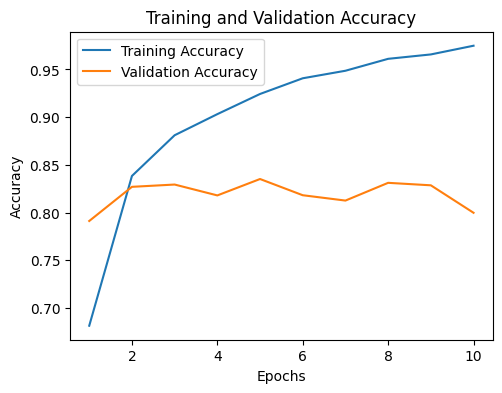

In [35]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()



Understanding padding and masking
Using an Embedding layer with masking enabled

In [43]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model_1 =model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9708 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

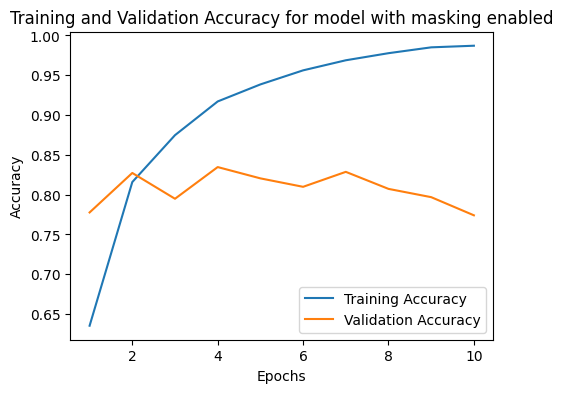

In [44]:
accuracy = model_1.history['accuracy']
val_accuracy = model_1.history['val_accuracy']

loss = model_1.history["loss"]
val_loss = model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy for model with masking enabled")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Changing the number of training samples to  200 to see the performance of embedding layer built from scratch.

In [39]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(200)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [40]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru with increased train samples.keras",
                                    save_best_only=True)
]
model_2= model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru with increased train samples.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9707 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

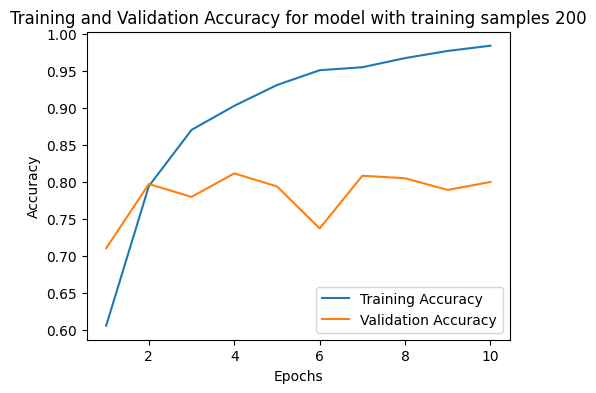

In [45]:
accuracy = model_2.history['accuracy']
val_accuracy = model_2.history['val_accuracy']

loss = model_2.history["loss"]
val_loss = model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy for model with training samples 200")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Changing the number of training samples to  350.

In [46]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(1000)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [47]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru with increased training samples2.keras",
                                    save_best_only=True)
]
model_3=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru with increased training samples2.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9709 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_13 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

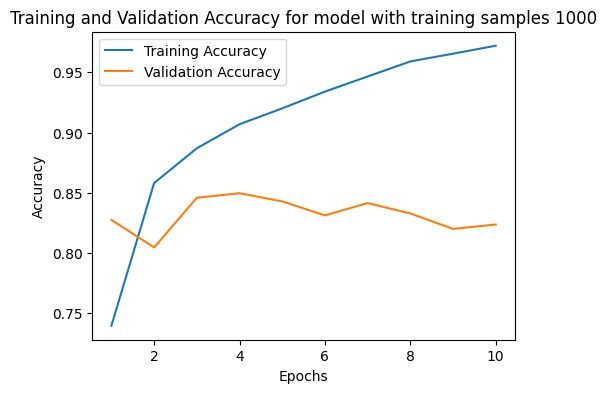

In [48]:
accuracy = model_3.history['accuracy']
val_accuracy = model_3.history['val_accuracy']

loss = model_3.history["loss"]
val_loss = model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy for model with training samples 1000")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [49]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(2000)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [50]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru with increased training samples3.keras",
                                    save_best_only=True)
]
model_4= model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru with increased training samples3.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9710 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

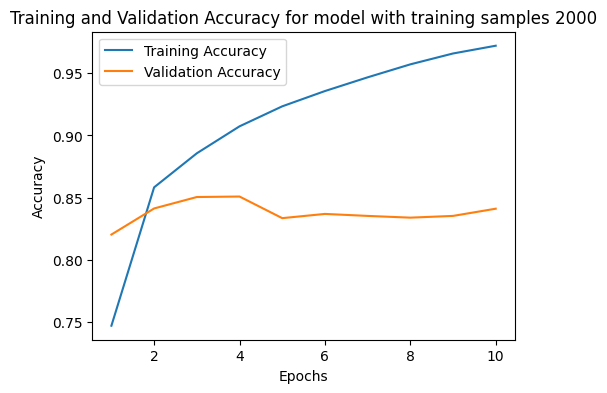

In [51]:
accuracy = model_4.history['accuracy']
val_accuracy = model_4.history['val_accuracy']

loss = model_4.history["loss"]
val_loss = model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy for model with training samples 2000")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [59]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(5000)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [60]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru with increased training samples4.keras",
                                    save_best_only=True)
]
model_5=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru with increased training samples4.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9717 (Embedding)  (None, None, 256)         2560000   
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               73984     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
________________________________________________

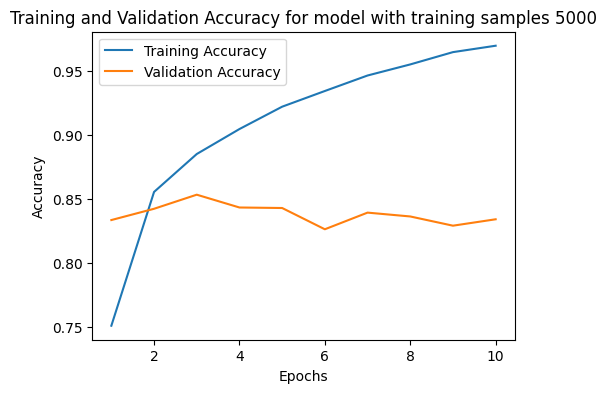

In [57]:
accuracy = model_5.history['accuracy']
val_accuracy = model_5.history['val_accuracy']

loss = model_5.history["loss"]
val_loss = model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy for model with training samples 5000")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Using pretrained word embeddings

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-11-27 21:41:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-27 21:41:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-27 21:41:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Parsing the GloVe word-embeddings file

In [24]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Preparing the GloVe word-embeddings matrix

In [25]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [61]:
num_training_samples = len(int_train_ds)
print(f"Number of training samples: {num_training_samples}")

Number of training samples: 625


Model that uses a pretrained Embedding layer with training sample size of 1000

In [27]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()




Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9704 (Embedding)  (None, None, 100)         1000000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,034,113
Trainable params: 34,113
Non-trainable params: 1,000,000
___________________________________________

In [64]:
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
Pre_model=model.fit(int_train_ds.take(1000), validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 25s 41ms/step - loss: 0.2079 - accuracy: 0.9237 - val_loss: 0.4156 - val_accuracy: 0.8428
Epoch 2/10
625/625 [==============================] - 16s 26ms/step - loss: 0.1794 - accuracy: 0.9362 - val_loss: 0.4410 - val_accuracy: 0.8408
Epoch 3/10
625/625 [==============================] - 15s 24ms/step - loss: 0.1527 - accuracy: 0.9468 - val_loss: 0.5060 - val_accuracy: 0.8414
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 0.1228 - accuracy: 0.9575 - val_loss: 0.6126 - val_accuracy: 0.8302
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1040 - accuracy: 0.9644 - val_loss: 0.5437 - val_accuracy: 0.8290
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 0.0854 - accuracy: 0.9714 - val_loss: 0.6190 - val_accuracy: 0.8328
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0652 - accuracy: 0.9779 - val_loss: 0.6809 - val_accuracy:

Model that uses a pretrained Embedding layer with training sample size of 5000

In [65]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
Pre_model2=model.fit(int_train_ds.take(5000), validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9704 (Embedding)  (None, None, 100)         1000000   
                                                                 
 bidirectional_18 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,034,113
Trainable params: 34,113
Non-trainable params: 1,000,000
___________________________________________